# Decision Tree

#### import libraries

In [100]:
import pandas as pd
import math
import networkx as nx
import matplotlib.pyplot as plt

### Picking dataset

In [101]:
df = pd.read_csv("data/gielda.txt")

df.head()

,age,access,wheel,trend
0,old,yes,swr,down
1,old,no,swr,down
2,old,no,hwr,down
3,mid,yes,swr,down
4,mid,yes,hwr,down


## 2. Entropy Calculation
Entropy measures the amount of uncertainty in a dataset.
The formula: H(S) = - \sum_{i=1}^c p_i \log_2(p_i)
where p_i is the proportion of label i in the set.

In [102]:
def entropy(labels):
    """
    Calculate the entropy of a list/Series of class labels.
    labels: iterable of class labels
    Returns: entropy value
    """
    counts = labels.value_counts()
    total = len(labels)
    ent = 0.0
    for count in counts:
        p = count / total
        ent -= p * math.log2(p)
    return ent

## 3. Information Gain

In [103]:
def information_gain(df, attribute, target_name="target"):
    """
    Compute the information gain of splitting df on attribute.
    df: pandas DataFrame
    attribute: column name to split on
    target_name: name of the target/class column
    Returns: information gain value
    """
    base_entropy = entropy(df[target_name])
    values = df[attribute].unique()
    weighted_ent = 0.0
    for val in values:
        subset = df[df[attribute] == val]
        weight = len(subset) / len(df)
        weighted_ent += weight * entropy(subset[target_name])
    return base_entropy - weighted_ent


## 4. Split Information and Gain Ratio

In [104]:
def split_info(df, attribute):
    """
    Compute the split information for attribute in df.
    """
    total = len(df)
    values = df[attribute].unique()
    split_info_val = 0.0
    for val in values:
        subset = df[df[attribute] == val]
        p = len(subset) / total
        split_info_val -= p * math.log2(p) if p > 0 else 0
    return split_info_val


def gain_ratio_metrics(df, attribute, target):
    g = information_gain(df, attribute, target)
    si = split_info(df, attribute)
    gr = g / si if si != 0 else 0
    return {'gain': g, 'split_info': si, 'gain_ratio': gr}

## 5. Building the ID3 Tree

In [105]:
# 5. Decision Node
def fmt(x): return f"{x:.4f}"
class DecisionNode:
    def __init__(self, attribute=None, label=None, entropy=None, gain=None, split_info=None, gain_ratio=None, samples=None):
        self.attribute = attribute
        self.label = label
        self.entropy = entropy
        self.gain = gain
        self.split_info = split_info
        self.gain_ratio = gain_ratio
        self.samples = samples
        self.branches = {}

def build_tree(df, attributes, target, use_gain_ratio=False):
    def recurse(subset, available_attrs):
        labels = subset[target]
        if len(labels.unique()) == 1:
            return DecisionNode(label=labels.iloc[0], samples=len(subset))
        if not available_attrs:
            return DecisionNode(label=labels.mode()[0], samples=len(subset))

        metrics = {}
        for attr in available_attrs:
            m = gain_ratio_metrics(subset, attr, target)
            score = m['gain_ratio'] if use_gain_ratio else m['gain']
            metrics[attr] = {**m, 'score': score}

        best_attr = max(metrics, key=lambda a: metrics[a]['score'])
        best = metrics[best_attr]
        node = DecisionNode(
            attribute=best_attr,
            entropy=entropy(subset[target]),
            gain=best['gain'],
            split_info=best['split_info'],
            gain_ratio=best['gain_ratio'],
            samples=len(subset)
        )

        for val, group in subset.groupby(best_attr):
            reduced = group.drop(columns=[best_attr])
            new_attrs = [a for a in available_attrs if a != best_attr]
            node.branches[val] = recurse(group, new_attrs)

        return node

    return recurse(df, attributes)

## Print the tree

In [106]:
def print_tree(node, depth=0):
    prefix = "  " * depth
    if node.label is not None:
        print(f"{prefix}Leaf: {node.label} (samples={node.samples})")
    else:
        ent_text = fmt(node.entropy)
        gain_text = fmt(node.gain)
        si_text = fmt(node.split_info)
        gr_text = fmt(node.gain_ratio)
        print(f"{prefix}{node.attribute}? [H={ent_text}, G={gain_text}, SI={si_text}, GR={gr_text}, N={node.samples}]")
        for val, branch in node.branches.items():
            print(f"{prefix}|-- {node.attribute} = {val}")
            print_tree(branch, depth + 1)


## NetworkX visualization

In [107]:
def visualize_tree(node):
    G = nx.DiGraph()

    def add(n, parent=None, edge_label=None, nid="0"):
        if n.label is not None:
            label = f"Leaf\n{n.label}\nN={n.samples}"
        else:
            label = f"{n.attribute}?\nH={fmt(n.entropy)}\nG={fmt(n.gain)}\nSI={fmt(n.split_info)}\nGR={fmt(n.gain_ratio)}\nN={n.samples}"
        G.add_node(nid, label=label)
        if parent:
            G.add_edge(parent, nid, label=edge_label)
        for i, (val, child) in enumerate(n.branches.items()):
            add(child, nid, val, f"{nid}.{i}")

    add(node)
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
    labels = nx.get_node_attributes(G, 'label')
    edge_labels = nx.get_edge_attributes(G, 'label')
    plt.figure(figsize=(16, 10))
    nx.draw(G, pos, labels=labels, with_labels=True, arrows=True,
            node_color='#ffefc5',
            node_size=4000, font_size=8, font_family='monospace')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
    plt.title("Decision Tree with Detailed Metrics")
    plt.axis('off')
    plt.show()

## Usage example

Building tree with Gain Ratio...


Tree with Metrics:

age? [H=1.0000, G=0.6000, SI=1.5710, GR=0.3819, N=10]
|-- age = mid
  access? [H=1.0000, G=1.0000, SI=1.0000, GR=1.0000, N=4]
  |-- access = no
    Leaf: up (samples=2)
  |-- access = yes
    Leaf: down (samples=2)
|-- age = new
  Leaf: up (samples=3)
|-- age = old
  Leaf: down (samples=3)


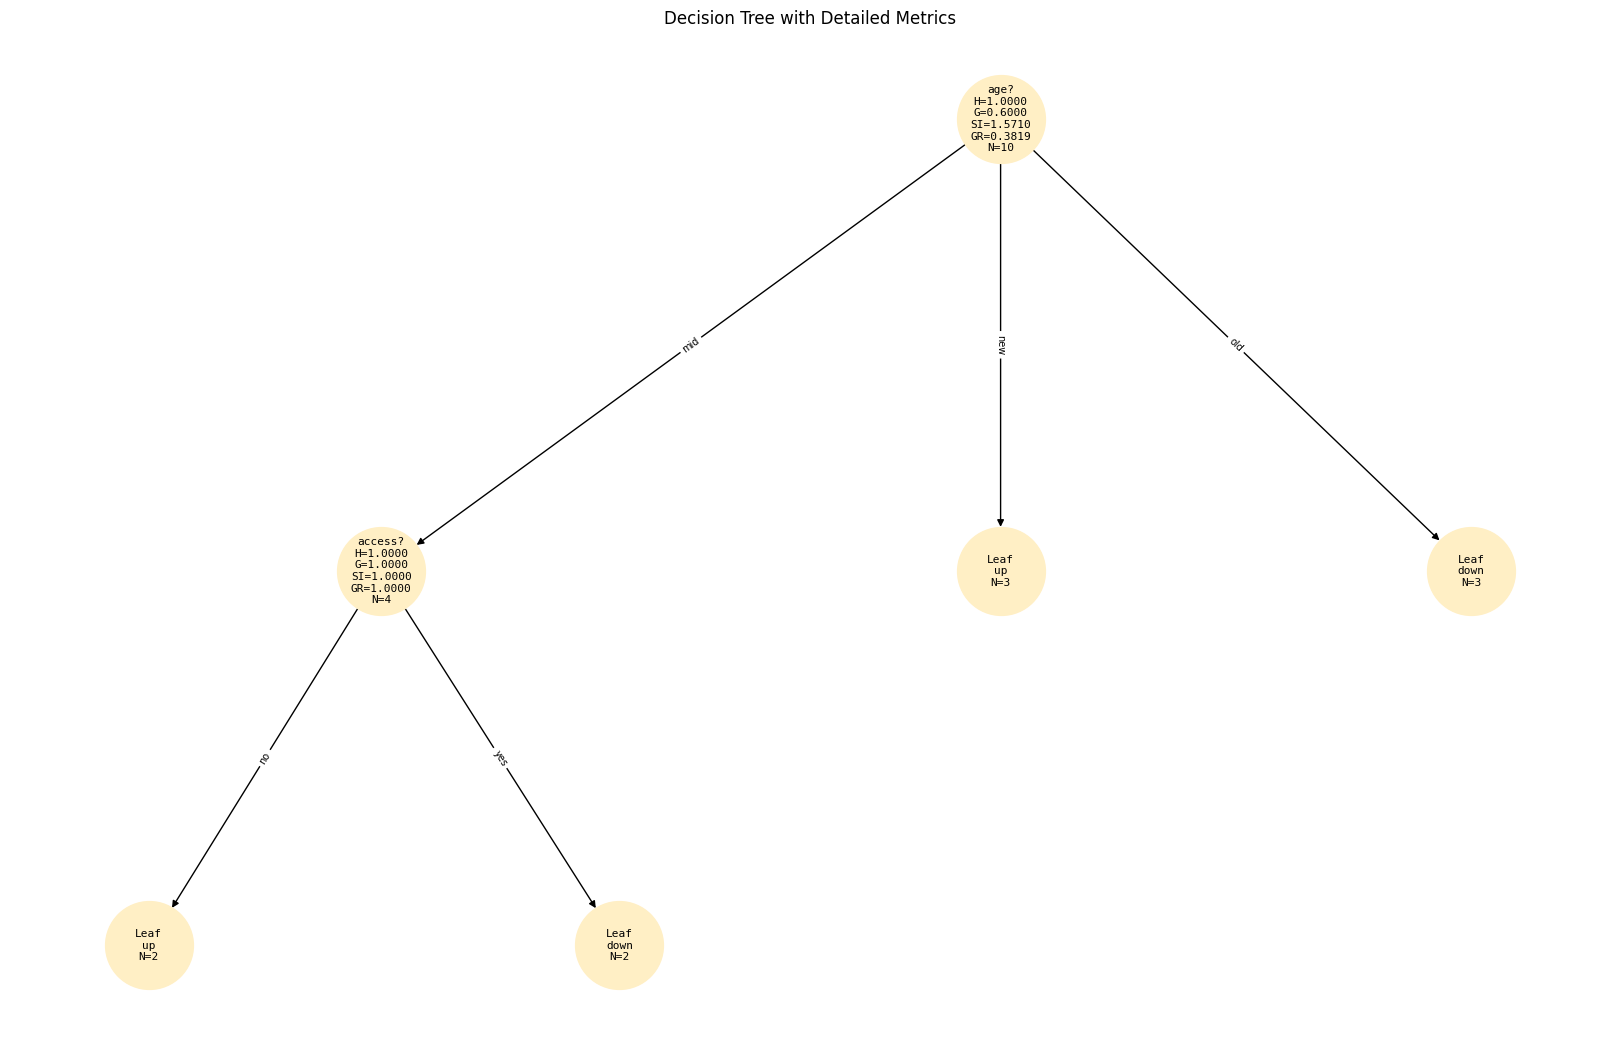

In [108]:
target = df.columns[-1]
attributes = df.drop(columns=target).columns.tolist()


print("Building tree with Gain Ratio...\n")
tree = build_tree(df, attributes, target, use_gain_ratio=True)
print("\nTree with Metrics:\n")
print_tree(tree)
visualize_tree(tree)
